# Key

- dm cm - daily mean "conus" mean (daily average, averaged over 1/8-degree contiguous US domain)
- mm cm - monthly mean "conus" (monthly average, averaged over 1/8-degree continuous US domain calculated from dm cm)

# Import libraries and paths


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import time

# FOr calculating gph and z
import sys
sys.path.append("../../helpers/")
import P_to_GPH_ncol
import importlib
importlib.reload(P_to_GPH_ncol)
p2gph = P_to_GPH_ncol.P_to_GPH_ncol

# Define functions

In [12]:
def derive_rho(ds_T): # Derive atmospheric mass density kg m^-3 (take care with units!)
        
    ds_rho = xr.Dataset()
    # Conversion constants
    R = 287.058 # J/ kg^-1 K^-1 => m^2 s^-2 K^-1
    to_Pa = 100 # convert from hPa to Pa. Pa => kg m^-1 s^-2
    ds_rho['rho'] = ds_T['lev']*to_Pa/(R*ds_T) # Units: kg m^-1 s^-2 * m^-2 s^2 K * K^-1 => kg m^-3

    return ds_rho 

def derive_n(ds_T): # Derive atmospheric number density - particles cm^-3 (take care with units!)

    ds_n = xr.Dataset()
    # Conversion constants
    k = 1.380649e-23 # Boltzmann constant J K^-1 = kg m^2 s^-2 K^-1
    to_cm3 = 1e6 # convertion from m^3 to cm^3
    to_Pa = 100 # convert from hPa to Pa. Pa = kg m^-1 s^-2
    ds_n['n'] = ds_T['lev']*to_Pa/(to_cm3*k*ds_T) # Units: kg m^-1 s^-2 * kg^-1 m^-2 s^2 K * K^-1 = m^-3 | m^-3 * 1e-6 = cm^-3
    
    return ds_n

def derive_w(ds_omega,ds_T): # Convert Pa/s to m/s (take care with units!)
    
    ds_w = xr.Dataset()
    ds_rho = derive_rho(ds_T) # Units: kg m^-1 s^-2 * m^-2 s^2 K * K^-1 => kg m^-3
    g = 9.80665 # m s^-2
    ds_w['w'] = -ds_omega/(ds_rho['rho']*g) # Units: kg m^-1 s^-2 * s^-1 * kg^-1 m^3 * m^-1 s^2 => m s^-1
    
    return ds_w

def calculate_daily_wtrans(mean_filenames,flux_filenames,file_str, writeon=False,path_out='../../data/processed_data/vertical_flx_wtrans/wtrans/daily/',year='2010'): # calculates wtrans in cm s-1
    dm_wtrans = []
    # Loop over daily fluxes and means
    for mean_file, flux_file in zip(mean_filenames,flux_filenames):
        
        # Read in files
        mean = xr.open_dataset(mean_file)
        flux = xr.open_dataset(flux_file)
        
        # Create and populate wtrans dataset
        wtrans = xr.Dataset()
        for var in ['T','O_n','NO_n','CO2_n','CO_n','H2O_n']:
            # Calculate transport velocities
            if var == 'T':
                wtrans[f'{var}_wtrans']= 100*flux[f'{var}_flux']/mean[var] # x 100 as units for heat flux are K m s-1, want wtrans in cm s-1
            else:
                wtrans[f'{var}_wtrans']= flux[f'{var}_flux']/mean[var]
                
        # Create time coordinate
        idateL = mean_file.find(year)
        idateU = mean_file.find('-0000')
        date = mean_file[idateL:idateU]
        wtrans['time'] = date
        wtrans = wtrans.set_coords('time').expand_dims('time') # Saves out date, allows reading in with open_mfdataset
        
        # Write dataset to file
        if writeon:
            print('writing wtrans for',file_str, date)
            wtrans.to_netcdf(path_out+f'on_lev_{file_str}_wtrans_{date}.nc')    
def get_daily_flux(file,lons,lats,vars,ilevs=[6,24]): # Calculate daily mean domain domain average flux

    # CONUS ranges
    lonL = lons[0] # lower
    lonU = lons[1] # upper
    latL = lats[0]
    latU = lats[1]
    ilevL = ilevs[0]
    ilevU = ilevs[1]
    
    # open dataset
    ds = xr.open_dataset(file)[vars].isel(lev=slice(ilevL,ilevU))
    
    # Get variables for prime calculations
    variables_for_prime = [x for x in vars if x not in ['lat','lon']]#,'area']]
    
    # isolate varibales from dataset
    ds_vars = ds[variables_for_prime] 
    x = ds.lon
    y = ds.lat
    
    # reduce dataset geographically
    ds_vars = ds_vars.where((y > latL) & (y < latU) & (x > lonL) & (x < lonU)).dropna(dim='ncol')
    # get weights for reduced region
    #weights = ds.area.where((y > latL) & (y < latU) & (x > lonL) & (x < lonU)).dropna(dim='ncol')
    weights = np.cos(np.deg2rad(ds.lat.where((y > latL) & (y < latU) & (x > lonL) & (x < lonU)).dropna(dim='ncol')))
    
    # ----------------------------------------
    # Perform conversions on variables to get 
    # - w in m s-1
    # - constituents in cm-3
    # Store all variables that will have fluxes computed in 
    # ds_for_prime
    # ----------------------------------------
    
    ds_for_prime = xr.Dataset()
    for var in variables_for_prime:
        if var == 'OMEGA':
            w = derive_w(ds_vars['OMEGA'],ds_vars['T'])
        if var not in ['T','OMEGA','U','V']: # constituents converted to number density
            ds_for_prime[f'{var}_n'] = ds_vars[var]*derive_n(ds_vars['T'])['n']
        if var in ['T','U','V']: # 
            ds_for_prime[var] = ds_vars[var]
      
    # End conversions ------------------------
      
    # Calculate w primes
    w_prime = w - w.mean(dim='time')
    # Calculate primes for all other variables
    ds_prime = ds_for_prime - ds_for_prime.mean(dim='time')    
    
    # ---------------------------------------
    # Calculate fluxes
    # ---------------------------------------
    ds_flux = xr.Dataset()
    for var in ds_for_prime.keys():
        
        # Set up units and multiplication factor 
        if '_n' in var:
            units_str = '( cm$^{-2}$ s$^{-1}$ )'
            factor = 100
        if var == 'T':
            units_str = '( Kelvin )'
            factor = 1
            
        ds_flux[f'{var}_flux'] = ( w_prime['w']*ds_prime[var] ).mean(dim='time').weighted(weights).mean(dim='ncol')*factor
        ds_flux[f'{var}_flux'].attrs['long_name'] = f'{var}_flux {units_str}'
    
    # End Calculate fluxes ------------------
    
    # Clean up memory
    del(ds)
    del(ds_vars)
    del(weights)
    del(w_prime)
    del(ds_prime)
    
    return ds_flux

def calculate_mean(file,lons,lats,vars,ilevs=[6,21]): # Computes daily mean conus mean of quantity

    # CONUS ranges
    lonL = lons[0] # lower
    lonU = lons[1] # upper
    latL = lats[0]
    latU = lats[1]
    ilevL = ilevs[0]
    ilevU = ilevs[1]
    # open dataset
    ds = xr.open_dataset(file)[vars].isel(lev=slice(ilevL,ilevU))
    
    # Get variables for prime calculations
    variables_for_mean = [x for x in vars if x not in ['lat','lon']]
    
    # isolate varibales from dataset
    ds_vars = ds[variables_for_mean] 
    x = ds.lon
    y = ds.lat
    
    # reduce dataset geographically
    ds_vars = ds_vars.where((y > latL) & (y < latU) & (x > lonL) & (x < lonU)).dropna(dim='ncol')
    # get weights for reduced region
    #weights = ds.area.where((y > latL) & (y < latU) & (x > lonL) & (x < lonU)).dropna(dim='ncol')
    weights = np.cos(np.deg2rad(ds.lat.where((y > latL) & (y < latU) & (x > lonL) & (x < lonU)).dropna(dim='ncol')))
    
    # ----------------------------------------
    # Perform conversions on variables to get 
    # - w in m s-1
    # - constituents in cm-3
    # Store all variables that will have fluxes computed in 
    # ds_for_prime
    # ----------------------------------------
    
    ds_for_mean = xr.Dataset()
    for var in variables_for_mean:
        if var == 'OMEGA':
            ds_for_mean['w'] = derive_w(ds_vars['OMEGA'],ds_vars['T'])['w']
        if var not in ['T','OMEGA','U','V']: # constituents converted to number density
            ds_for_mean[f'{var}_n'] = ds_vars[var]*derive_n(ds_vars['T'])['n']
            ds_for_mean[var] = ds_vars[var]
        if var in ['T','U','V']: # 
            ds_for_mean[var] = ds_vars[var]
      
    # End conversions ------------------------
      
    # Calculate mean
    ds_mean = ds_for_mean.mean(dim='time').weighted(weights).mean(dim='ncol')   
    
    
    # Clean up memory
    del(ds)
    del(ds_vars)
    del(weights)
    del(ds_for_mean)
    
    return ds_mean

def parse_days(day,month,year):
    indexing=[]
    # If explicitly told to use all days that month:
    if 'all' in day:
        #print("Case: all")
        indexing=[None,None]
    #If the list is empty, use all days  
    elif not day: 
        #print("Case: empty")
        indexing=[None,None]
    #Otherwise, start and end are set explicitly
    else:
        #Starting value first:
        #If it is a number:
        #print('Start position:')
        if str(day[0]).isnumeric():
            #print(f'{day[0]} is numeric')
            #If it's 0, append 0, since it would end up as -1 otherwise
            if int(day[0])==0:
                #print(f'{day[0]} is 0')
                indexing.append(0)
            # If it is another number, start at value-1 (because indexing from 0)
            else:
                #print(f'{day[0]}, so starting from {int(day[0])-1}')
                indexing.append(int(day[0])-1)
        else: # start at the beginning of the month
            #print(f'{day[0]} is not numeric, starting from 0')
            indexing.append(0)
        #Now consider the end of the month
        #print('End position')
        if str(day[1]).isnumeric():
            #print(f'{day[0]} is numeric')
            #If it's 0, append 0, since it would end up as -1 otherwise
            if int(day[0])==0:
                #print(f'{day[0]} is 0')
                indexing.append(0)
            #Any other number
            else:
                #set upper allowable limit on day number
                if int(month) in [4,6,9,11]: # Max 30 days
                    maxval=30
                elif int(month)==2:
                    if int(year)%4==0: #leap year, allow max 29 days
                        maxval=29
                    else:
                        maxval=28
                else:
                    maxval=31
                # append the relevand stopping position
                #run to value given if before end of month
                if int(day[1]) < maxval:
                    #print(f'{day[1]}, so ending at {int(day[1])}')
                    indexing.append(int(day[1]))
                #run to end of month if equal to or beyond end of month
                elif int(day[1]) >= maxval:
                    if int(day[1]) > maxval:
                        #warn if beyond end of month
                        print(f'{day}/{month}/{year} is not a valid date!')
                    #print(f'{day[1]}, so ending at {int(day[1])} (end of month)')
                    indexing.append(None)
        else: # End of month is not a number
            #print(f'{day[0]} is not numeric, running to end of month')
            indexing.append(None)

    if len(indexing) !=2:
        print(f'Had trouble parsing "{day}", got "{indexing}". Using whole month.')
        indexing=[None,None]
    #print(f'From "{day}", got "{indexing}"')
    return indexing

def name_file(var_list):
    name=""
    hierarchy = ['OMEGA','T','NO','O','CO2','CO','H2O'] # the order variables should appear in the filename
    for val in hierarchy:
        if val in var_list:
            name=name+val+'_'
    if 'OMEGA' in name:
        name=name.replace('OMEGA','w')
    return name

# q - compute daily mean (dm)  

#### How to specify a range of days
The settings below allow for the daily means to be calculated for any range of days.

```python
year = '2010'
month = ['06']
days = [[1,1]] 
```
Any number of months can be specified. For each month, provide a list of days in the form *[start,end]* (inclusive).   
The days should be the actual days (i.e. starting from 1), though it will cope if you hand it a 0, and should be in increasing order.  
The days must **always** be a **list of lists**. They can be strings or integers.  

To include **all days in a month**, the list should be ``` days = [['all']]``` or ```days = [[]]```  
To run from the start of the month to a particular day, or from a particular day to the end, you can use 'start' and 'end' instead of the dates.  

The system assumes all days have been calculated, i.e. that there are 28-31 files per month. It counts through them in order to find the correct days, it does not read in the filenames. Therefore if you only have one day in a given month (e.g. 26th) available, giving it *[26,26]* will cause it to crash as it will look for entry 25 in a list of length 1. It should in this case be given *['all]'* or *[1,1]*.  

To include multiple months, list all months and provide day lists for each. This can also be used to get two non-continuous periods from the same month.  

##### Examples
- All of one month (e.g. June): ```month = ['06']``` and ```days = [[]]```  
- One day from one month (e.g. 1st June): ```month = ['06']``` and ```days = [[1,1]]```  
- A period from one month (e.g. 2nd - 7th June): ```month = ['06']``` and ```days = [[2,7]]```  
- A period to the end of the month (e.g. 10th June - end of June): ```month = ['06']``` and ```days = [[10,end]]```  
- All of two months (e.g. June and December): ```month = ['06','12']``` and ```days = [[],[]]```
- Two periods within a month (e.g. 1st - 4th and 6th-12th December): ```month = ['12','12']``` and ```days = [[1,4],[6,12]]```  
- A period spanning three months (e.g. 14th May - 7th July): ```month = ['05','06','07']``` and ```days = [[14,'end'],[],['start',7]]```  

In [3]:
#===================================================
# Settings for daily mean calculations
#===================================================

#---------------------------------------------------
# Paths to input and daily mean output
#---------------------------------------------------
raw_data_path = '/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/'
output_data_path = '../../data/processed_data/vertical_flx_wtrans/time_domain_means/'

#---------------------------------------------------
# Specify the year, month(s) and range of days in each month to use. See above for guidance!
#---------------------------------------------------
year = '2010'                                       # The year
month = ['06']                                      # Specify list of all months to use, in order
days = [['all']]                                    # Specify range of days to use each month. Must be list of lists, one list per month

#---------------------------------------------------
# General controls
#---------------------------------------------------
variables = ['T','NO','O','CO2','CO','H2O']         # Variables to be averaged over ['T','NO','O','CO2','CO','H2O']
ilevs = [0,110]                                     # Index of levels to use (model top = 0, 111 = surface)
use_area='conus'                                    # Specify the region to use: 'conus', 'sor' (starfire optical range), or custom

save_individual_days = True                         # Save daily average files?
auto_set_filename = True                            # If True, code will generate the filenames automatically with the region and variables
print_file_list = True                              # Will print a list of the files it is using if true

#---------------------------------------------------
# Custom settings! - if use_area is not one of the presets, or auto_set_filename = False, determine filenames and lat/lon ranges here 
#---------------------------------------------------
outname_nonrr_c = f'nonrr_sor_mean_w_T_NO_O_CO2_CO_H2O_'     # Not used if auto_set_filename = True
outname_rr_c = f'rr_sor_mean_w_T_NO_O_CO2_CO_H2O_'           # Not used if auto_set_filename = True

lons = [252,256]                                             # Not used if use_area = 'conus' or 'sor'
lats = [33,37]                                               # Not used if use_area = 'conus' or 'sor'

#---------------------------------------------------
# Bookkeeping for presets settings
#---------------------------------------------------
# Latitude and longitude
if use_area == 'conus':                              # Using preset latitude and longitude for continental US
    area_str = 'cm'
    lons = [240,285] # lonL, lonU
    lats = [22,52] # latL, latU
    print("Using CONUS region")
elif use_area =='sor':                               # Using preset latitude and longitude for Starfire optical range
    area_str = 'sor'
    lons = [252,256] 
    lats = [33,37] 
    print("Using Starfire optical region")
else:
    print("Using custom lat and lon")
    area_str == use_area

#Include lat and lon (and omega) in vars
vars=['lat','lon']+variables                   

#set subfolders to Non-RR and RR data
path_in_nonrr = f'{raw_data_path}Non-RR/'
path_in_rr = f'{raw_data_path}RR/'

#set output filenames
if auto_set_filename == False:
    q_dm_outname_nonrr =  outname_nonrr_c
    q_dm_outname_rr =  outname_rr_c
else:
    if ilevs == [0,110]:
        fullcol='fullcol_'
    else:
        fullcol=''
    q_dm_outname_nonrr = f'nonrr_{area_str}_mean_{name_file(vars)}{fullcol}'
    q_dm_outname_rr = f'rr_{area_str}_mean_{name_file(vars)}{fullcol}'

#----------------------------------------------------
# Check days are entered correctly
#---------------------------------------------------
if len(month) != len(days):
    print("You must provide one list of start and end dates for each month!")


#===================================================
# Read in the files!
#===================================================
files_nonrr=[]
files_rr=[]
for mon, day in zip(month,days):
    [i0,iL]=parse_days(day,mon,year)
    files_nonrr = files_nonrr+sorted(glob.glob(f'{path_in_nonrr}*h0*{year}-{month}*'))[i0:iL]
    files_rr = files_rr+sorted(glob.glob(f'{path_in_rr}*h0*{year}-{month}*'))[i0:iL]

#Printing

if print_file_list == True:
    print("Non-RR files:")
    for file in files_nonrr: print(file)
    print("\nRR files:")
    for file in files_rr: print(file)

Using CONUS region
Non-RR files:
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-01-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-02-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-03-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-04-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-05-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-06-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_fil

In [4]:
#===================================================
# Calculate daily mean average quantities of variables
#===================================================

tic = time.time()

for file_nonrr, file_rr in zip(files_nonrr,files_rr):
    loop_tic1 = time.time()
    
    date_index = file_nonrr.find(f'{year}-')
    print(f'processing {file_nonrr[date_index:-3]}')

    # Process Non-RR mean
    ds_nonrr_mean = calculate_mean(file_nonrr,lons,lats,vars,ilevs)
    loop_tic2 = time.time()
    print(f'processing nonrr mean took {loop_tic2 - loop_tic1:.2f} seconds')
    
    # Process RR mean
    ds_rr_mean = calculate_mean(file_rr,lons,lats,vars,ilevs)
    loop_tic3 = time.time()
    print(f'processing rr mean took {loop_tic3 - loop_tic2:.2f} seconds')
    
    if save_individual_days:     
        ds_nonrr_mean.to_netcdf(f'{output_data_path}daily/{q_dm_outname_nonrr}{file_nonrr[date_index:]}')
        ds_rr_mean.to_netcdf(f'{output_data_path}daily/{q_dm_outname_rr}{file_nonrr[date_index:]}')

toc=time.time()

print(f'That whole process took {(toc - tic)/60:.2f} minutes')
     

processing 2010-06-01-00000
processing nonrr mean took 29.11 seconds
processing rr mean took 57.53 seconds
processing 2010-06-02-00000
processing nonrr mean took 24.26 seconds
processing rr mean took 103.69 seconds
processing 2010-06-03-00000
processing nonrr mean took 23.75 seconds
processing rr mean took 98.95 seconds
processing 2010-06-04-00000
processing nonrr mean took 20.95 seconds
processing rr mean took 97.55 seconds
processing 2010-06-05-00000
processing nonrr mean took 30.52 seconds
processing rr mean took 99.42 seconds
processing 2010-06-06-00000
processing nonrr mean took 25.20 seconds
processing rr mean took 81.19 seconds
processing 2010-06-07-00000
processing nonrr mean took 21.68 seconds
processing rr mean took 131.11 seconds
processing 2010-06-08-00000
processing nonrr mean took 34.14 seconds
processing rr mean took 134.09 seconds
processing 2010-06-09-00000
processing nonrr mean took 20.49 seconds
processing rr mean took 140.61 seconds
processing 2010-06-10-00000
proce

# q - compute monthly mean (mm)

In [6]:
#===================================================
# Calculate domain mean quantity profiles from daily means and write to file
# ==================================================

#---------------------------------------------------
# Paths to input and daily mean output
#---------------------------------------------------
dm_path = '../../data/processed_data/vertical_flx_wtrans/time_domain_means/daily/'
path_out = '../../data/processed_data/vertical_flx_wtrans/time_domain_means/monthly/'

#---------------------------------------------------
# Specify time range
#---------------------------------------------------
year='2010'
month = ['06']                                       # Range of months. Each is mean is calculated for a given month, not over all of them

#---------------------------------------------------
# Names of files to use:
#---------------------------------------------------
use_prev_filename = True                             # Uses the filename when daily means were produced
custom_filestr = 'sor_mean_T_fullcol'                # Custom name to use if not using previous names
print_file_list = True                               # Print list of files being used for the calculation

#---------------------------------------------------
# Generate filename:
#---------------------------------------------------
if use_prev_filename == False:
    q_mm_filestr = custom_filestr                        # Use custom filestring if requested
else:
    q_mm_filestr = q_dm_outname_rr[3:-1]                 # Removes rr_ and _ from start and end of q dailty mean output filestring
print(f'Looking for {q_mm_filestr} files')                    # Prints the filestring being used (for error checking)

#===================================================
# Get list of files
# ==================================================
mean_files_nonrr = []
mean_files_rr = []
for mon in month:
    mean_files_nonrr.append(sorted(glob.glob(f'{dm_path}/nonrr_*{q_mm_filestr}*{year}-{mon}*')))
    mean_files_rr.append(sorted(glob.glob(f'{dm_path}/rr_*{q_mm_filestr}*{year}-{mon}*')))

# Print file list

if print_file_list == True:
    for mon,nonrr_files,rr_files in zip(month,mean_files_nonrr,mean_files_rr):
        print(f'\nMonth {mon}')
        print('Non-RR files:')
        for file in nonrr_files: print(file)
        print('RR files:')
        for file in rr_files: print(file)
        

Looking for cm_mean_T_NO_O_CO2_CO_H2O_fullcol files

Month 06
Non-RR files:
../../data/processed_data/vertical_flx_wtrans/time_domain_means/daily/nonrr_cm_mean_T_NO_O_CO2_CO_H2O_fullcol_2010-06-01-00000.nc
../../data/processed_data/vertical_flx_wtrans/time_domain_means/daily/nonrr_cm_mean_T_NO_O_CO2_CO_H2O_fullcol_2010-06-02-00000.nc
../../data/processed_data/vertical_flx_wtrans/time_domain_means/daily/nonrr_cm_mean_T_NO_O_CO2_CO_H2O_fullcol_2010-06-03-00000.nc
../../data/processed_data/vertical_flx_wtrans/time_domain_means/daily/nonrr_cm_mean_T_NO_O_CO2_CO_H2O_fullcol_2010-06-04-00000.nc
../../data/processed_data/vertical_flx_wtrans/time_domain_means/daily/nonrr_cm_mean_T_NO_O_CO2_CO_H2O_fullcol_2010-06-05-00000.nc
../../data/processed_data/vertical_flx_wtrans/time_domain_means/daily/nonrr_cm_mean_T_NO_O_CO2_CO_H2O_fullcol_2010-06-06-00000.nc
../../data/processed_data/vertical_flx_wtrans/time_domain_means/daily/nonrr_cm_mean_T_NO_O_CO2_CO_H2O_fullcol_2010-06-07-00000.nc
../../data/pro

In [7]:
# Non-RR
for mon,files in zip(month,mean_files_nonrr):
    ds_list = []
    for file in files:
        #Create list of each day's datasets
        ds_list.append(xr.open_dataset(file))
    # Make one dataset of the daily means and take the time average
    ds = xr.concat(ds_list,dim='time').mean(dim='time')
    # Save the monthly mean file
    file_out_str = f'on_lev_nonrr_{q_mm_filestr}_{year}-{mon}.nc'
    ds.to_netcdf(path_out + file_out_str)

# RR
for mon,files in zip(month,mean_files_rr):
    ds_list = []
    for file in files:
        #Create list of dateset for each day
        ds_list.append(xr.open_dataset(file))
    # Make one dataset of the daily means and take the time average
    ds = xr.concat(ds_list,dim='time').mean(dim='time')
    # Save the monthly mean file
    file_out_str = f'on_lev_rr_{q_mm_filestr}_{year}-{mon}.nc'
    ds.to_netcdf(path_out + file_out_str)


# q - interp to z

In [8]:
#---------------------------------------------------
# Path to daily mean files
#---------------------------------------------------
use_files = 'monthly'                                # 'daily' or 'monthly' to do interpolation on daily files or monthly files

path_inout = '../../data/processed_data/vertical_flx_wtrans/time_domain_means/'

#---------------------------------------------------
# Specify time range
#---------------------------------------------------
year='2010'
month = ['06']                                       # Range of months. Each is mean is claculated for a given month, not over all of them

#---------------------------------------------------
# Names of files to use:
#---------------------------------------------------
# input data filenames
use_prev_filename = True                            # Uses the filename when daily means were produced
custom_filestr = 'cm_flx_monthly_mean'              # Custom name to use if not using previous names

print_file_list = True                              # Will print a list of the files it is using if true
inspect_ds = True                                   # Print ds.keys for lev and z files after calculating z

# Output filenames:
use_auto_outfile = True                             # Automatically adds z to filenames
out_filestr_c = 'sor_mean_z_fullcol'                # Custom name to use if not using autonaming
#---------------------------------------------------
# Generate filename:
#---------------------------------------------------
if use_prev_filename == False:
    filestr = custom_filestr                        # Use custom filestring if requested
else:
    filestr = q_dm_outname_rr[3:-1]                 # Removes rr_ and _ from start and end of q daily mean filestring
print(f'Looking for {filestr} files')               # Prints filestring for files being used (for error checking)

if use_files == 'monthly':                          # Monthly mean files start with "on_lev", daily do not
    starter='on_lev_'
else:
    if use_files != 'daily':                        # If option is neither 'monthly' or 'daily', isssue a warning and use daily files
        print(f'Could not parse use_files = "{use_files}"! Using daily!')
    starter=''                                      # Daily files do not have 'on_lev' at the start

if use_auto_outfile == True:
    # filestr is 'rr_{area_str}_mean_{name_file(vars)}{fullcol}'
    # keep '{are_str}_mean'
    # add '_z'
    # keep '_{name_file(vars)}{fullcol}'
    # q_z_out_filestr becomes '{area_str}_mean_z_{name_file(vars)}{fullcol}'
    q_z_out_filestr = f'{filestr[:4+filestr.find('mean')]}_z{filestr[4+filestr.find('mean'):]}'
else:
    q_z_out_filestr = out_filestr_c                 # Use custom out_filestr
print(f'Saving as {q_z_out_filestr} files')         # Print q_z_out_filestr for checking
#===================================================
# Get list of files
# ==================================================

all_files_nonrr = []
all_files_rr = []
for mon in month:
    all_files_nonrr.append(sorted(glob.glob(f'{path_inout}{use_files}/{starter}nonrr*{filestr}*{year}-{mon}*')))
    all_files_rr.append(sorted(glob.glob(f'{path_inout}{use_files}/{starter}rr*{filestr}*{year}-{mon}*')))

# Print file list

if print_file_list == True:
    for mon,nonrr_files,rr_files in zip(month,all_files_nonrr,all_files_rr):
        print(f'\nMonth {mon}')
        print('Non-RR files:')
        for file in nonrr_files: print(file)
        print('RR files:')
        for file in rr_files: print(file)

Looking for cm_mean_T_NO_O_CO2_CO_H2O_fullcol files
Saving as cm_mean_z_T_NO_O_CO2_CO_H2O_fullcol files

Month 06
Non-RR files:
../../data/processed_data/vertical_flx_wtrans/time_domain_means/monthly/on_lev_nonrr_cm_mean_T_NO_O_CO2_CO_H2O_fullcol_2010-06.nc
RR files:
../../data/processed_data/vertical_flx_wtrans/time_domain_means/monthly/on_lev_rr_cm_mean_T_NO_O_CO2_CO_H2O_fullcol_2010-06.nc


In [9]:
for mon,files_nonrr,files_rr in zip(month,all_files_nonrr,all_files_rr):
    ds_nonrr = []
    ds_rr = []
    # Create lists of Non-RR and RR datasets for each month
    for file_nonrr,file_rr in zip(files_nonrr,files_rr):
        ds_nonrr.append(xr.open_dataset(file_nonrr))
        ds_rr.append(xr.open_dataset(file_rr))

    # Concatenate days to create two datasets
    ds_nonrr = xr.concat(ds_nonrr,dim='time')
    ds_rr = xr.concat(ds_rr,dim='time')
    
    if inspect_ds == True:
        print("Non-RR:")
        print(ds_nonrr.keys)
        print("\nRR:")
        print(ds_rr.keys)

    print('\n\nCalculating z for non-RR:')
    ds_nonrr_with_z = p2gph(ds_nonrr)
    print('\nCalculating z for RR:')
    ds_rr_with_z = p2gph(ds_rr)

    if inspect_ds == True:
        print("\nNon-RR:")
        print(ds_nonrr_with_z.keys)
        print("\nRR:")
        print(ds_rr_with_z.keys)

    # Save datasets with z included as a variable to files
    ds_nonrr_with_z.to_netcdf(path_inout+f'{use_files}/{starter}nonrr_{q_z_out_filestr}_{year}-{mon}.nc')
    ds_rr_with_z.to_netcdf(path_inout+f'{use_files}/{starter}rr_{q_z_out_filestr}_{year}-{mon}.nc')

    

Non-RR:
<bound method Mapping.keys of <xarray.Dataset> Size: 11kB
Dimensions:  (time: 1, lev: 110)
Coordinates:
  * lev      (lev) float64 880B 6.14e-06 9.453e-06 1.455e-05 ... 976.3 992.6
Dimensions without coordinates: time
Data variables:
    T        (time, lev) float64 880B 535.7 502.2 456.3 ... 294.8 295.7 296.1
    NO_n     (time, lev) float64 880B 3.386e+07 4.872e+07 ... 9.032e+09
    NO       (time, lev) float64 880B 0.0004094 0.0003592 ... 1.1e-10 3.717e-10
    O_n      (time, lev) float64 880B 1.86e+10 2.629e+10 ... 3.701e+03 4.008e+03
    O        (time, lev) float64 880B 0.2235 0.1923 ... 1.551e-16 1.658e-16
    CO2_n    (time, lev) float64 880B 4.05e+06 8.37e+06 ... 9.366e+15 9.511e+15
    CO2      (time, lev) float64 880B 4.863e-05 6.039e-05 ... 0.0003916
    CO_n     (time, lev) float64 880B 5.645e+06 9.07e+06 ... 1.53e+12 1.752e+12
    CO       (time, lev) float64 880B 6.792e-05 6.615e-05 ... 7.204e-08
    H2O_n    (time, lev) float64 880B 2.312e+03 5.431e+03 ... 4.318

# flx - compute daily mean (dm)

In [10]:
#===================================================
# Settings for daily mean calculations
#===================================================

#---------------------------------------------------
# Paths to input and daily mean output
#---------------------------------------------------
raw_data_path = '/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/' # TODO will get changed!
output_data_path = '../../data/processed_data/vertical_flx_wtrans/flux/'

#---------------------------------------------------
# Specify the year, month(s) and range of days in each month to use. See above for guidance!
#---------------------------------------------------
year = '2010'                                       # The year
month = ['06']                                      # Specify list of all months to use, in order
days = [['all']]                                    # Specify range of days to use each month. Must be list of lists, one list per month

#---------------------------------------------------
# General controls
#---------------------------------------------------
variables = ['T','NO','O','CO2','CO','H2O']         # Variables to calculate mean flux for: ['T','NO','O','CO2','CO','H2O']

ilevs = [6,24]                                      # Index of levels to use (model top = 0, 111 = surface)
use_area='conus'                                    # Specify the region to use: 'conus', 'sor' (starfire optical range), or 'custom'

save_individual_days = True                         # Save daily average files?
auto_set_filename = True                            # If True, code will generate the filenames automatically with the region and variables
print_file_list = True                              # Will print a list of the files it is using if true

#---------------------------------------------------
# Custom settings! - if use_area = 'custom', or auto_set_filename = False, determine them here 
#---------------------------------------------------
outname_nonrr_c = 'nonrr_cm_mean_w_T_NO_O_CO2_CO_H2O_'      # Not used if auto_set_filename = True
outname_rr_c = 'rr_cm_mean_w_T_NO_O_CO2_CO_H2O_'            # Not used if auto_set_filename = True

lons = [240,285]                                            # Not used if use_area = 'conus' or 'sor'
lats = [33,37]                                              # Not used if use_area = 'conus' or 'sor'

#---------------------------------------------------
# Bookkeeping for presets settings
#---------------------------------------------------
# Latitude and longitude
if use_area == 'conus':                              # Use lat and lon range for continental US
    area_str = 'cm'
    lons = [240,285] # lonL, lonU
    lats = [22,52] # latL, latU
    print("Using CONUS region")
elif use_area =='sor':                               # Use lat and lon range for Starfire optical range
    area_str = 'sor'
    lons = [252,256]  
    lats = [33,37] 
    print("Using Starfire optical region")
else:
    print("Using custom lat and lon")
    area_str == 'customarea'

#Include lat and lon and omega in vars
vars=['OMEGA','lat','lon']+variables

#set subfolders to Non-RR and RR data
path_in_nonrr = f'{raw_data_path}Non-RR/'
path_in_rr = f'{raw_data_path}RR/'

if auto_set_filename == False:
    flx_dm_outname_nonrr =  outname_nonrr_c     # Use custom filenames
    flx_dm_outname_rr =  outname_rr_c
else:
    if ilevs == [0,110]:                        # Include fullcol label if using surface to TOA
        fullcol='fullcol_'
    else:
        fullcol=''
    #Construct output name
    flx_dm_outname_nonrr = f'nonrr_{area_str}_flx_{name_file(vars)}{fullcol}'
    flx_dm_outname_rr = f'rr_{area_str}_flx_{name_file(vars)}{fullcol}'

#----------------------------------------------------
# Check days are entered correctly
#---------------------------------------------------
if len(month) != len(days):
    print("You must provide one list of start and end dates for each month!")


#===================================================
# Read in the files!
#===================================================
files_nonrr=[]
files_rr=[]
for mon, day in zip(month,days):
    [i0,iL]=parse_days(day,mon,year)
    files_nonrr = files_nonrr+sorted(glob.glob(f'{path_in_nonrr}*h0*{year}-{month}*'))[i0:iL]
    files_rr = files_rr+sorted(glob.glob(f'{path_in_rr}*h0*{year}-{month}*'))[i0:iL]

#Printing files to be used
if print_file_list == True:
    print("Non-RR files:")
    for file in files_nonrr: print(file)
    print("\nRR files:")
    for file in files_rr: print(file)

Using CONUS region
Non-RR files:
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-01-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-02-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-03-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-04-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-05-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_files/June/Non-RR/nonrr_extracted_FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.2010-06-06-00000.nc
/resstore/b0243/Data/mmkupilas/rr_nonrr_fil

In [14]:
tic = time.time()

for file_nonrr, file_rr in zip(files_nonrr,files_rr):
    loop_tic1 = time.time()
    
    date_index = file_nonrr.find(f'{year}-')
    print(f'processing {file_nonrr[date_index:-3]}')
    
    # Process Non-RR Flux
    flux_nonrr = get_daily_flux(file_nonrr,lons,lats,vars)
    loop_tic2 = time.time()
    print(f'processing flux_nonrr took {loop_tic2 - loop_tic1:.2f} seconds')
    
    # Process RR flux
    flux_rr = get_daily_flux(file_rr,lons,lats,vars)
    loop_tic3 = time.time()
    print(f'processing flux_rr took {loop_tic3 - loop_tic2:.2f} seconds')
    
    if save_individual_days:
        flux_nonrr.to_netcdf(f'{output_data_path}daily/{flx_dm_outname_nonrr}{file_nonrr[date_index:]}')
        flux_rr.to_netcdf(f'{output_data_path}daily/{flx_dm_outname_rr}{file_nonrr[date_index:]}')

toc=time.time()

print(f'That whole process took {(toc - tic)/60:.2f} minutes')

# Takes ~ 1 min for Non-RR fluxes to be computed for a single day
# Takes ~ 1 min 40s for a RR fluxes be computed for a single day 

     

processing 2010-06-01-00000
processing flux_nonrr took 1.75 seconds


KeyboardInterrupt: 

# flx - compute monthly mean (mm)

In [15]:
#===================================================
# Calculate fluxes from daily mean flux and write to file
# ==================================================

#---------------------------------------------------
# Paths to input and daily mean output
#---------------------------------------------------
dm_path = '../../data/processed_data/vertical_flx_wtrans/flux/daily/'
path_out = '../../data/processed_data/vertical_flx_wtrans/flux/monthly/'

#---------------------------------------------------
# Specify time range
#---------------------------------------------------
year='2010'
month = ['06']                                       # Range of months. Each is mean is claculated for a given month, not over all of them

#---------------------------------------------------
# Names of files to use:
#---------------------------------------------------
use_prev_filename = True                             # Uses the filename when daily means were produced
custom_filestr = 'cm_flx'                            # Custom name to use if not using previous names

print_file_list = True                               # Prints list of files being used if true
inspect_ds = True                                    # Prints ds.keys for files if true

flx_mm_file_outname = 'cm_flx_monthly_mean'          # Name to save data with

#---------------------------------------------------
# Generate filename:
#---------------------------------------------------
if use_prev_filename == False:
    flx_mm_filestr = custom_filestr                   # Use custom filestring if requested
else:
    flx_mm_filestr = flx_dm_outname_rr[3:-1]          # Removes rr_ and _ from start and end of daily mean flux filestring
print(f'Looking for {flx_mm_filestr} files')          # Print filestring being used (for checking)


#===================================================
# Get list of files
# ==================================================
flux_files_nonrr = []
flux_files_rr = []
for mon in month:
    flux_files_nonrr.append(sorted(glob.glob(f'{dm_path}/nonrr_*{flx_mm_filestr}*{year}-{mon}*')))
    flux_files_rr.append(sorted(glob.glob(f'{dm_path}/rr_*{flx_mm_filestr}*{year}-{mon}*')))

# Print file list
if print_file_list == True:
    for mon,nonrr_files,rr_files in zip(month,flux_files_nonrr,flux_files_rr):
        print(f'\nMonth {mon}')
        print('Non-RR files:')
        for file in nonrr_files: print(file)
        print('RR files:')
        for file in rr_files: print(file)


Looking for cm_flx_w_T_NO_O_CO2_CO_H2O files

Month 06
Non-RR files:
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-01-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-02-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-03-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-04-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-05-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-06-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-07-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-08-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/

In [16]:
for mon,files_nonrr_flux,files_rr_flux in zip(month,flux_files_nonrr,flux_files_rr):
    ds_nonrr = []
    ds_rr = []
    #create lists of Non-RR and RR datasets
    for file_nonrr,file_rr in zip(files_nonrr_flux,files_rr_flux):
        ds_nonrr.append(xr.open_mfdataset(file_nonrr))
        ds_rr.append(xr.open_mfdataset(file_rr))
    
    # Concatenate datasets
    ds_nonrr = xr.concat(ds_nonrr,dim='time')
    ds_rr = xr.concat(ds_rr,dim='time')

    if inspect_ds == True:
        print("Non-RR:")
        print(ds_nonrr.keys)
        print("\nRR:")
        print(ds_rr.keys)

    # Calculate monthly mean flux
    print('\n\nCalculating mean fluxes') 
    flux_nonrr = ds_nonrr.mean(dim='time')
    flux_rr = ds_rr.mean(dim='time')

    if inspect_ds == True:
        print("\nNon-RR:")
        print(flux_nonrr.keys)
        print("\nRR:")
        print(flux_rr.keys)

    # Calculate std from daily means and add to flux dataset
    print('\n\nCalculating standard deviation of fluxes') 
    for key in ds_nonrr.keys():
        flux_nonrr[key+'_std'] = ds_nonrr[key].std(dim='time')
        flux_rr[key+'_std'] = ds_rr[key].std(dim='time')   

    if inspect_ds == True:
        print("\nNon-RR:")
        print(flux_nonrr.keys)
        print("\nRR:")
        print(flux_rr.keys)

    # Save monthly mean fluxes to files
    flux_nonrr.to_netcdf(path_out + f'on_lev_nonrr_{flx_mm_file_outname}_{year}-{mon}.nc')
    flux_rr.to_netcdf(path_out + f'on_lev_rr_{flx_mm_file_outname}_{year}-{mon}.nc')

Non-RR:
<bound method Mapping.keys of <xarray.Dataset> Size: 26kB
Dimensions:     (time: 30, lev: 18)
Coordinates:
  * lev         (lev) float64 144B 8.156e-05 0.0001254 ... 0.06711 0.09899
Dimensions without coordinates: time
Data variables:
    T_flux      (time, lev) float64 4kB dask.array<chunksize=(1, 18), meta=np.ndarray>
    NO_n_flux   (time, lev) float64 4kB dask.array<chunksize=(1, 18), meta=np.ndarray>
    O_n_flux    (time, lev) float64 4kB dask.array<chunksize=(1, 18), meta=np.ndarray>
    CO2_n_flux  (time, lev) float64 4kB dask.array<chunksize=(1, 18), meta=np.ndarray>
    CO_n_flux   (time, lev) float64 4kB dask.array<chunksize=(1, 18), meta=np.ndarray>
    H2O_n_flux  (time, lev) float64 4kB dask.array<chunksize=(1, 18), meta=np.ndarray>>

RR:
<bound method Mapping.keys of <xarray.Dataset> Size: 26kB
Dimensions:     (time: 30, lev: 18)
Coordinates:
  * lev         (lev) float64 144B 8.156e-05 0.0001254 ... 0.06711 0.09899
Dimensions without coordinates: time
Data varia

# flx - interp to z

In [17]:
#---------------------------------------------------
# Path to monthly mean files
#---------------------------------------------------
path_on_z = '../../data/processed_data/vertical_flx_wtrans/time_domain_means/monthly/'
path_inout = '../../data/processed_data/vertical_flx_wtrans/flux/monthly/'

#---------------------------------------------------
# Specify time range
#---------------------------------------------------
year='2010'
month = ['06']                                       # Range of months to append z for

#---------------------------------------------------
# Names of files to use:
#---------------------------------------------------
# input data filenames
use_prev_filename_z = True                          # Uses the filename for monthly mean q values on z if True
custom_filestr_z = 'cm_flx'                         # Custom name to use if not using previous names

use_prev_filename_flx = True                        # Uses the monthly mean flux filename if True
custom_filestr_flx = 'cm_flx'                       # Uses a custom filestring if not using previous name

# Output filenames:
use_auto_outfile = True                             # Automatically adds z to filenames if True
out_filestr_c = 'sor_mean_z_fullcol'                # Custom name to use if not using autonaming

#---------------------------------------------------
# General controls:
#---------------------------------------------------
print_file_list = True                              # Will print a list of the files it is using if true
inspect_ds = True                                   # Print ds.keys for lev and z files after calculating z

plot_examples = True                                # Will plot example profiles on lev and z
plot_for = ['T_flux','O_n_flux']                    # Variables to plot examples for

save_out = True                                     # Will save the monthly means to a new file. Reccomended to switch this off and check data the first time


#---------------------------------------------------
# Generate filename:
#---------------------------------------------------
if use_prev_filename_z == False:
    flx_z_filestr = custom_filestr_z                 # Use custom filestring for z files if requested
else:
    flx_z_filestr = q_z_out_filestr                  # Use output filename from q_z monthly means
print(f'Looking for {flx_z_filestr} files for z values')

if use_prev_filename_flx == False:
    flx_filestr = custom_filestr_flx                 # Use custom filestring for mm flx if requested
else:
    flx_filestr = flx_mm_file_outname                # Use output filename from flx monthly means
print(f'Looking for {flx_filestr} files for mean flux values')

if use_auto_outfile == True:
    flx_z_out_filestr = flx_filestr                  # Use the input name string as the output name if using auto (will be on_z, not on_lev) - CHECK
else:
    flx_z_out_filestr = out_filestr_c                # Use custom out_filestr
print(f'Saving as {flx_z_out_filestr} files')

#===================================================
# Get list of files
# ==================================================
# q monthly mean on z files:
all_files_nonrr_z = []
all_files_rr_z = []
for mon in month:
    all_files_nonrr_z.append(sorted(glob.glob(f'{path_on_z}/on_lev_nonrr*{q_z_out_filestr}*{year}-{mon}*')))
    all_files_rr_z.append(sorted(glob.glob(f'{path_on_z}/on_lev_rr*{q_z_out_filestr}*{year}-{mon}*')))

    # If lists are empty, no files found, issue warning
if not all_files_nonrr_z:
    print(f'Could not find files "{path_on_z}/on_lev_nonrr*{q_z_out_filestr}*{year}-{mon}*", have you calculated z for monthly mean q files?')
if not all_files_rr_z:
    print(f'Could not find files "{path_on_z}/on_lev_rr*{q_z_out_filestr}*{year}-{mon}*", have you calculated z for monthly mean q files?')

# monthly mean flux files
all_files_nonrr = []
all_files_rr = []
for mon in month:
    all_files_nonrr.append(sorted(glob.glob(f'{path_inout}/on_lev_nonrr*{flx_filestr}*{year}-{mon}*')))
    all_files_rr.append(sorted(glob.glob(f'{path_inout}/on_lev_rr*{flx_filestr}*{year}-{mon}*')))

# Print file list
if print_file_list == True:
    for mon,nonrr_files,rr_files,nonrr_files_z,rr_files_z in zip(month,all_files_nonrr,all_files_rr,all_files_nonrr_z,all_files_rr_z):
        print(f'\nMonth {mon}')
        print('Non-RR flux files:')
        for file in nonrr_files: print(file)
        print('Non-RR z files:')
        for file in nonrr_files_z: print(file)
        print('RR flux files:')
        for file in rr_files: print(file)
        print('RR z files:')
        for file in rr_files_z: print(file)

Looking for cm_mean_z_T_NO_O_CO2_CO_H2O_fullcol files for z values
Looking for cm_flx_monthly_mean files for mean flux values
Saving as cm_flx_monthly_mean files

Month 06
Non-RR flux files:
../../data/processed_data/vertical_flx_wtrans/flux/monthly/on_lev_nonrr_cm_flx_monthly_mean_2010-06.nc
Non-RR z files:
../../data/processed_data/vertical_flx_wtrans/time_domain_means/monthly/on_lev_nonrr_cm_mean_z_T_NO_O_CO2_CO_H2O_fullcol_2010-06.nc
RR flux files:
../../data/processed_data/vertical_flx_wtrans/flux/monthly/on_lev_rr_cm_flx_monthly_mean_2010-06.nc
RR z files:
../../data/processed_data/vertical_flx_wtrans/time_domain_means/monthly/on_lev_rr_cm_mean_z_T_NO_O_CO2_CO_H2O_fullcol_2010-06.nc


Using levL,levU: 0.09899012366076931 8.155804209764028e-05
Non-RR z: lev L U: 0.09899012366076931 8.155804209764028e-05
RR z: lev L U: 0.09899012366076931 8.155804209764028e-05

Non-RR:
<bound method Mapping.keys of <xarray.Dataset> Size: 2kB
Dimensions:         (lev: 18)
Coordinates:
  * lev             (lev) float64 144B 8.156e-05 0.0001254 ... 0.06711 0.09899
Data variables: (12/13)
    T_flux          (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    NO_n_flux       (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    O_n_flux        (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    CO2_n_flux      (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    CO_n_flux       (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    H2O_n_flux      (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    ...              ...
    NO_n_flux_std   (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray

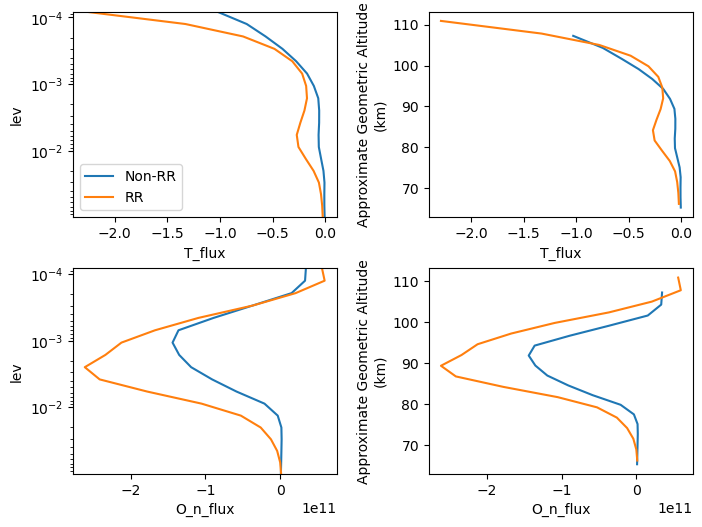

In [18]:
for mon,nonrr_files,rr_files,nonrr_files_z,rr_files_z in zip(month,all_files_nonrr,all_files_rr,all_files_nonrr_z,all_files_rr_z):
    for nonrr_file, rr_file,nonrr_file_z, rr_file_z in zip(nonrr_files,rr_files,nonrr_files_z,rr_files_z):
        flux_nonrr = xr.open_mfdataset(nonrr_file)
        flux_rr = xr.open_mfdataset(rr_file)
        
        # Get bounds of flux pressure range
        # Assumes nonrr and rr fluxes on same pressure range
        levU = np.min(flux_nonrr.lev.values)
        levL = np.max(flux_rr.lev.values)
        print('Using levL,levU:', levL, levU)

        z_nonrr = xr.open_mfdataset(nonrr_file_z).sel(lev=slice(levU,levL)).isel(time=0) # only one time value in the z file, but we don't want a (1,18) shape for z
        z_rr = xr.open_mfdataset(rr_file_z).sel(lev=slice(levU,levL)).isel(time=0)

        print('Non-RR z: lev L U:', np.max(z_nonrr.lev.values), np.min(z_nonrr.lev.values))
        print('RR z: lev L U:', np.max(z_rr.lev.values), np.min(z_rr.lev.values))

        flux_nonrr['z'] = z_nonrr['z']
        flux_rr['z'] = z_rr['z']

        if inspect_ds == True:
            print("\nNon-RR:")
            print(flux_nonrr.keys)
            print("\nRR:")
            print(flux_rr.keys)

        flux_nonrr_on_z = flux_nonrr.swap_dims({'lev':'z'}).reset_coords('lev')
        flux_rr_on_z = flux_rr.swap_dims({'lev':'z'}).reset_coords('lev')

        if inspect_ds == True:
            print("\nNon-RR:")
            print(flux_nonrr_on_z.keys)
            print("\nRR:")
            print(flux_rr_on_z.keys)

        if plot_examples == True:
            fig = plt.figure(figsize=(8,3*len(plot_for)))
            axs=fig.subplots(nrows=len(plot_for),ncols=2)
            #plot each variable in specified list on pressure and z
            for i,var in enumerate(plot_for):
                flux_nonrr[var].plot(ax=axs[i,0],y='lev',yscale='log',ylim=[levL,levU],label='Non-RR')
                flux_rr[var].plot(ax=axs[i,0],y='lev',yscale='log',ylim=[levL,levU],label='RR')
                flux_nonrr_on_z[var].plot(ax=axs[i,1],y='z')
                flux_rr_on_z[var].plot(ax=axs[i,1],y='z')
                if i==0: axs[i,0].legend()
            fig.subplots_adjust(wspace=0.35,hspace=0.25)
            plt.show()

        if save_out == True:
            flux_nonrr_on_z.to_netcdf(path_inout + f'on_z_nonrr_{flx_z_out_filestr}_{year}-{mon}.nc')
            flux_rr_on_z.to_netcdf(path_inout + f'on_z_rr_{flx_z_out_filestr}_{year}-{mon}.nc')

# w trans - compute daily mean (dm)

In [22]:
# --------------------------------------------------------------
# COMPUTE DAILY WTRANS PROFILES FROM DAILY FLUXES AND MEANS
# Read in flux and quantity daily means 
# Since daily files do not have a time dimension, need to glob and read one by one
# And then use xr.concat(list_of_daily_datasets)
# --------------------------------------------------------------

#---------------------------------------------------
# Paths to input and daily mean output
#---------------------------------------------------
path_in_flux = '../../data/processed_data/vertical_flx_wtrans/flux/daily/'
path_in_q = '../../data/processed_data/vertical_flx_wtrans/time_domain_means/daily/'
path_out = '../../data/processed_data/vertical_flx_wtrans/wtrans/daily/'

#---------------------------------------------------
# Specify time range
#---------------------------------------------------
year='2010'
month = ['06']                                       # Range of months to use. It will use all available days
    
#---------------------------------------------------
# Names of files to use:
#---------------------------------------------------
use_prev_flux = True                                 # Uses the filename when daily mean fluxes were produced
use_prev_q = True                                    # Uses the filename when daily mean qs were produced

mean_str = 'cm_mean_T_NO_'                           # Custom q mean name to use if not using previous names
flux_str = 'cm_flx_T_NO_'                            # Custom flux name to use if not using previous names

w_dm_file_outname = 'cm'                             # Output name - rr/nonrr and w_trans and date will be added automatically

#---------------------------------------------------
# General controlls
#---------------------------------------------------
print_file_list = True                               # Print list of files found if true
save_outfiles = True                                 # Save daily mean files

#---------------------------------------------------
# Generate filename:
#---------------------------------------------------
if use_prev_filename == False:                       # Use custom filestrings if requested
    w_q_dm_filestr = mean_str
    w_flx_dm_filestr = flux_filestr                        
else:
    w_q_dm_filestr = q_dm_outname_rr[3:-1]           # Removes rr_ and _ from start and end of q daily mean filestring
    w_flx_dm_filestr = flx_dm_outname_rr[3:-1]       # Removes rr_ and _ from start and end of flux daily mean filestring
print(f'Looking for {w_q_dm_filestr} files')         # Prints filenaems to use (for checking)
print(f'Looking for {w_flx_dm_filestr} files')


#===================================================
# Get list of files
# ==================================================

flux_files_nonrr = []
flux_files_rr = []
q_files_nonrr = []
q_files_rr = []
for mon in month:
    
    flux_files_nonrr.append(sorted(glob.glob(f'{path_in_flux}/nonrr_*{w_flx_dm_filestr}*{year}-{mon}*')))
    flux_files_rr.append(sorted(glob.glob(f'{path_in_flux}/rr_*{w_flx_dm_filestr}*{year}-{mon}*')))

    q_files_nonrr.append(sorted(glob.glob(f'{path_in_q}/nonrr_*{w_q_dm_filestr}*{year}-{mon}*')))
    q_files_rr.append(sorted(glob.glob(f'{path_in_q}/nonrr_*{w_q_dm_filestr}*{year}-{mon}*')))

#Quick check:
for i,mon in enumerate(month):
    if len(q_files_rr[i]) != len(flux_files_rr[i]):
        print(f'WARNING! There are {len(q_files_rr[i])} q RR files but {len(flux_files_rr[i])} flux RR files for month {mon}! Printing file list!')
        print_file_list = True
    if len(q_files_nonrr[i]) != len(flux_files_nonrr[i]):
        print(f'WARNING! There are {len(q_files_nonrr[i])} q Non-RR files but {len(flux_files_nonrr[i])} flux Non-RR files for month {mon}! Printing file list!')
        print_file_list = True

# Print file list
if print_file_list == True:
    for mon,nonrr_files_f,rr_files_f,nonrr_files_q,rr_files_q in zip(month,flux_files_nonrr,flux_files_rr,q_files_nonrr,q_files_rr):
        print(f'\nMonth {mon}')
        print('Non-RR flux files:')
        for file in nonrr_files_f: print(file)
        print('Non-RR q files:')
        for file in nonrr_files_q: print(file)
        print('\nRR flux files:')
        for file in rr_files_f: print(file)
        print('RR q files:')
        for file in rr_files_q: print(file)


Looking for cm_mean_T_NO_O_CO2_CO_H2O_fullcol files
Looking for cm_flx_w_T_NO_O_CO2_CO_H2O files

Month 06
Non-RR flux files:
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-01-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-02-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-03-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-04-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-05-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-06-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-07-00000.nc
../../data/processed_data/vertical_flx_wtrans/flux/daily/nonrr_cm_flx_w_T_NO_O_CO2_CO_H2O_2010-06-08-000

In [23]:
for mon,flux_nonrr_files,flux_rr_files,mean_nonrr_files,mean_rr_files in zip(month,flux_files_nonrr,flux_files_rr,q_files_nonrr,q_files_rr):
    calculate_daily_wtrans(mean_nonrr_files,flux_nonrr_files,file_str='nonrr_'+w_dm_file_outname,writeon=save_outfiles,path_out=path_out,year=year)
    calculate_daily_wtrans(mean_rr_files,flux_rr_files,file_str='rr_'+w_dm_file_outname,writeon=save_outfiles,path_out=path_out,year=year)

writing wtrans for nonrr_cm 2010-06-01
writing wtrans for nonrr_cm 2010-06-02
writing wtrans for nonrr_cm 2010-06-03
writing wtrans for nonrr_cm 2010-06-04
writing wtrans for nonrr_cm 2010-06-05
writing wtrans for nonrr_cm 2010-06-06
writing wtrans for nonrr_cm 2010-06-07
writing wtrans for nonrr_cm 2010-06-08
writing wtrans for nonrr_cm 2010-06-09
writing wtrans for nonrr_cm 2010-06-10
writing wtrans for nonrr_cm 2010-06-11
writing wtrans for nonrr_cm 2010-06-12
writing wtrans for nonrr_cm 2010-06-13
writing wtrans for nonrr_cm 2010-06-14
writing wtrans for nonrr_cm 2010-06-15
writing wtrans for nonrr_cm 2010-06-16
writing wtrans for nonrr_cm 2010-06-17
writing wtrans for nonrr_cm 2010-06-18
writing wtrans for nonrr_cm 2010-06-19
writing wtrans for nonrr_cm 2010-06-20
writing wtrans for nonrr_cm 2010-06-21
writing wtrans for nonrr_cm 2010-06-22
writing wtrans for nonrr_cm 2010-06-23
writing wtrans for nonrr_cm 2010-06-24
writing wtrans for nonrr_cm 2010-06-25
writing wtrans for nonrr_

# w trans - mm cm from dm cm

In [24]:
# --------------------------------------------------------------
# CALCULATE MONTHLY MEAN WTRANS AND STD FROM DAILY MEAN WTRANS 
# Read in daily mean w trans profiles and compute monthly mean
# Since daily files do not have a time dimension, need to glob and read one by one
# And then use xr.concat(list_of_daily_datasets)
# --------------------------------------------------------------

#---------------------------------------------------
# Paths to input and daily mean output
#---------------------------------------------------
path_in = '../../data/processed_data/vertical_flx_wtrans/wtrans/daily/'
path_out = '../../data/processed_data/vertical_flx_wtrans/wtrans/monthly/'

#---------------------------------------------------
# Specify time range
#---------------------------------------------------
year='2010'
month = ['06']                                       # Range of months. Each is mean is claculated for a given month, not over all of them

#---------------------------------------------------
# Names of files and variables to use:
#---------------------------------------------------
use_prev_filename = True                             # Uses the daily mean wtrans filestring
c_file_str = 'cm'                                    # Custom filestring if use_prev_filename = False

use_vars = ['T','O_n','CO2_n','NO_n','CO_n','H2O_n'] # Variables to calculate wtrans mean and std for

#---------------------------------------------------
# General controls:
#---------------------------------------------------
print_file_list = True                               # Print list of files being used
save_outfiles = True                                 # Save monthly mean wtrans files
inspect_ds = True                                    # Print ds.keys

plot_examples = True                                 # Will plot example profiles on lev
plot_for = ['T_wtrans','O_n_wtrans']                 # Plot examples of mean and std for these variables (can be any subset of use_vars, with _wtrans appended)

#---------------------------------------------------
# Generate filename:
#---------------------------------------------------
if use_prev_filename == False:                       # Use custom filestring if requested
    w_dm_filestr = c_file_str
else:
    w_dm_filestr = w_dm_file_outname                 # Use filestring from dm wtrans calculation
print(f'Looking for {w_dm_filestr} files')           # Print filestring being used (for checking)

w_mm_out_filestr = w_dm_filestr+"_wtrans"            # Output filename is input filestr + _wtrans

#===================================================
# Get list of files
# ==================================================
all_files_nonrr = []
all_files_rr = []
for mon in month:
    all_files_nonrr.append(sorted(glob.glob(path_in+f'on_lev_nonrr_{w_dm_filestr}_wtrans_{year}-{mon}*')))
    all_files_rr.append(sorted(glob.glob(path_in+f'on_lev_rr_{w_dm_filestr}_wtrans_{year}-{mon}*')))

# Print file list
if print_file_list == True:
    for mon,nonrr_files,rr_files in zip(month,all_files_nonrr,all_files_rr):
        print(f'\nMonth {mon}')
        print('Non-RR files:')
        for file in nonrr_files: print(file)
        print('RR files:')
        for file in rr_files: print(file)


Looking for cm files

Month 06
Non-RR files:
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-01.nc
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-02.nc
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-03.nc
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-04.nc
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-05.nc
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-06.nc
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-07.nc
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-08.nc
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-09.nc
../../data/processed_data/vertical_flx_wtrans/wtrans/daily/on_lev_nonrr_cm_wtrans_2010-06-1

Reading in wtrans values
Plotting examples


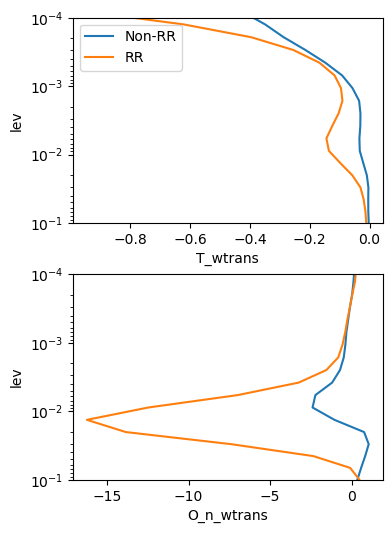

Calculating mean and standard deviation!


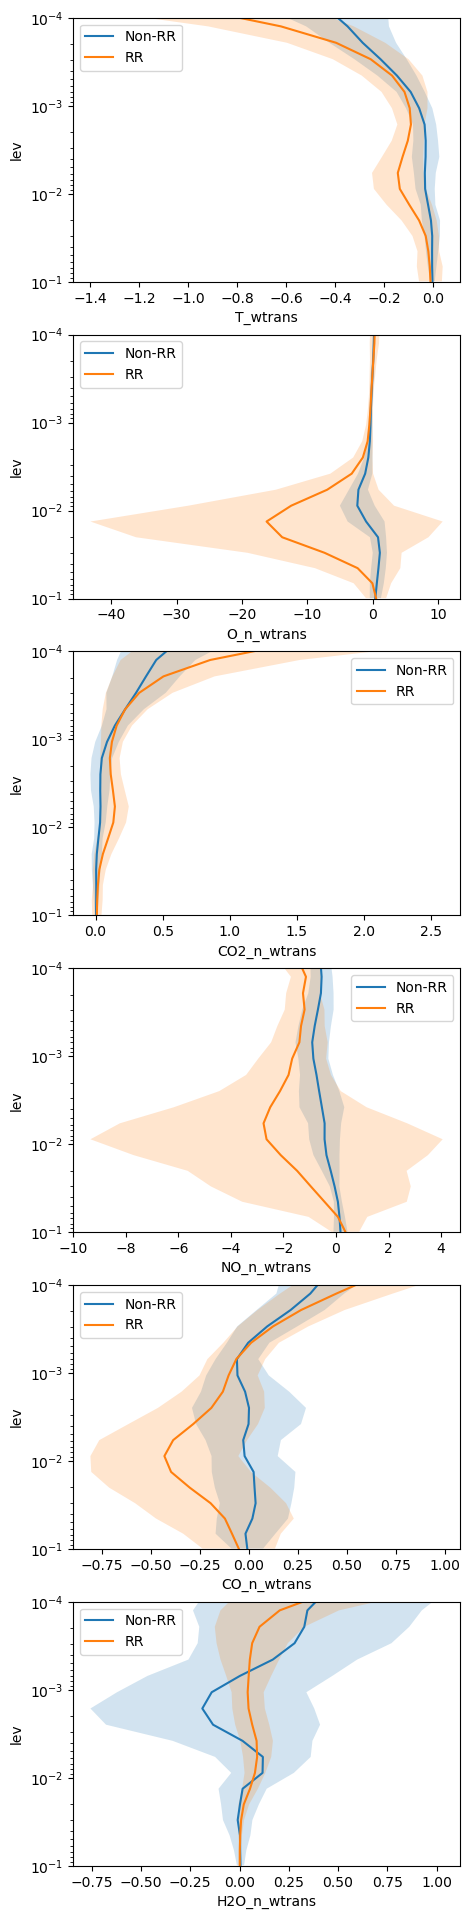


Non-RR:
<bound method Mapping.keys of <xarray.Dataset> Size: 2kB
Dimensions:           (lev: 18)
Coordinates:
  * lev               (lev) float64 144B 8.156e-05 0.0001254 ... 0.06711 0.09899
Data variables:
    T_wtrans          (lev) float64 144B -0.4258 -0.3492 ... -0.004078 -0.002731
    O_n_wtrans        (lev) float64 144B 0.1777 0.1237 0.04306 ... 0.59 0.3651
    NO_n_wtrans       (lev) float64 144B -0.5955 -0.5494 ... 0.1303 0.1684
    CO2_n_wtrans      (lev) float64 144B 0.5953 0.4517 ... 0.004153 0.002772
    CO_n_wtrans       (lev) float64 144B 0.384 0.3126 ... -0.01821 -0.009017
    H2O_n_wtrans      (lev) float64 144B 0.4259 0.3445 ... 0.003303 0.004931
    T_wtrans_std      (lev) float64 144B 0.1199 0.08446 ... 0.00876 0.004633
    O_n_wtrans_std    (lev) float64 144B 0.06671 0.07674 ... 0.5338 0.4263
    CO2_n_wtrans_std  (lev) float64 144B 0.1902 0.1459 ... 0.008843 0.004664
    NO_n_wtrans_std   (lev) float64 144B 0.1926 0.2084 0.2402 ... 0.1043 0.1334
    CO_n_wtrans_s

In [25]:
# Read in daily files 
for mon,files_nonrr,files_rr in zip(month,all_files_nonrr,all_files_rr):
    wtrans_nonrr = []
    wtrans_rr = []
    for file_nonrr, file_rr in zip(files_nonrr,files_rr):
        wtrans_nonrr.append(xr.open_dataset(file_nonrr))
        wtrans_rr.append(xr.open_dataset(file_rr))
 
    wtrans_nonrr = xr.concat(wtrans_nonrr,dim='time') # creates a new "time" dimension
    wtrans_rr = xr.concat(wtrans_rr,dim='time')
    print("Reading in wtrans values")
    
    if plot_examples == True:
        print("Plotting examples")
        fig = plt.figure(figsize=(4,3*len(plot_for)))
        axs=fig.subplots(nrows=len(plot_for),ncols=1)
        for i,var in enumerate(plot_for):
            wtrans_nonrr.mean(dim='time')[var].plot(ax=axs[i],y='lev',yscale='log',ylim=[1e-1,1e-4],label='Non-RR')
            wtrans_rr.mean(dim='time')[var].plot(ax=axs[i],y='lev',yscale='log',ylim=[1e-1,1e-4],label='RR')
            if i==0: axs[0].legend()
        fig.subplots_adjust(wspace=0.3,hspace=0.25)
        plt.show()

    wtrans_monthly_nonrr = wtrans_nonrr.mean(dim='time')
    wtrans_monthly_rr = wtrans_rr.mean(dim='time')

    print("Calculating mean and standard deviation!")
    # Compute monthly error
    for var in use_vars:
        wtrans_monthly_nonrr[f'{var}_wtrans_std'] = wtrans_nonrr[f'{var}_wtrans'].std(dim='time')
        wtrans_monthly_rr[f'{var}_wtrans_std'] = wtrans_rr[f'{var}_wtrans'].std(dim='time')

    if plot_examples == True:
        ds1 = wtrans_monthly_nonrr #renamed for brevity!
        ds2 = wtrans_monthly_rr
        
        use_all_vars = [var+'_wtrans' for var in use_vars]
        fig = plt.figure(figsize=(5,4*len(use_all_vars)))
        axs=fig.subplots(nrows=len(use_all_vars),ncols=1)
        
        for i,var in enumerate(use_all_vars):
            #Non-RR
            wtrans1 = ds1[var].values
            std1 = ds1[f'{var}_std'].values
            y1 = ds1.lev.values
            ds1[var].plot(y='lev',ax=axs[i],label='Non-RR')
            axs[i].fill_betweenx(y1,wtrans1-2*std1,wtrans1+2*std1,alpha=0.2,edgecolor=None)

            #RR
            wtrans2 = ds2[var].values
            std2 = ds2[f'{var}_std'].values
            y2 = ds2.lev.values
            ds2[var].plot(y='lev',ax=axs[i],label='RR')
            axs[i].fill_betweenx(y2,wtrans2-2*std2,wtrans2+2*std2,alpha=0.2)

            axs[i].set_ylim(1e-1,1e-4)
            axs[i].set_yscale('log')
            axs[i].legend()
        plt.show()

    if inspect_ds == True:
        print("\nNon-RR:")
        print(wtrans_monthly_nonrr.keys)
        print("\nRR:")
        print(wtrans_monthly_rr.keys)

    if save_outfiles == True:
        print('Saving monthly means!')
        wtrans_monthly_nonrr.to_netcdf(path_out + f'on_lev_nonrr_{w_mm_out_filestr}_{year}-{mon}.nc')
        wtrans_monthly_rr.to_netcdf(path_out + f'on_lev_rr_{w_mm_out_filestr}_{year}-{mon}.nc')

# w trans - interp to z

In [26]:
# Read in wtrans

#---------------------------------------------------
# Path to monthly mean files
#---------------------------------------------------
path_on_z = '../../data/processed_data/vertical_flx_wtrans/time_domain_means/monthly/'
path_inout = '../../data/processed_data/vertical_flx_wtrans/wtrans/monthly/'

#---------------------------------------------------
# Specify time range
#---------------------------------------------------
year='2010'
month = ['06']                                       # Range of months. Each is mean is calculated for a given month, not over all of them

#---------------------------------------------------
# Names of files to use:
#---------------------------------------------------
# input data filenames
use_prev_filename_z = True                          # Uses the filename when monthly mean q values on z were produced
custom_filestr_z = 'cm_flx'                         # Custom name to use if not using previous names

use_prev_filename_w = True                          # Uses the filename when monthly mean wtrans values were calculated
custom_filestr_w = 'cm_wtrans'                      # Custom name to use if not using previous names

#---------------------------------------------------
# General controls:
#---------------------------------------------------
print_file_list = True                              # Will print a list of the files it is using if true
inspect_ds = True                                   # Print ds.keys for lev and z files after calculating z
plot_examples = True                                # Will plot example profiles on lev and z
plot_for = ['T_wtrans','O_n_wtrans']
save_out = True                                     # Suggested to switch this off until data has been checked

#---------------------------------------------------
# Generate filename:
#---------------------------------------------------
if use_prev_filename_w == False:
    w_mm_filestr = custom_filestr_w                      # Use custom filestring files if requested
else:
    w_mm_filestr = w_mm_out_filestr                      # Looking for output filename from w monthly means
print(f'Looking for {w_mm_filestr} files for w values')  # Print filestr (for checking)

if use_prev_filename_z == False:
    w_z_filestr = custom_filestr_z                       # Use custom filestring for z files if requested
else:
    w_z_filestr = q_z_out_filestr                        # Looking for output filename from q_z monthly means
print(f'Looking for {w_z_filestr} files for z values')   # Print filestr (for checking)


#===================================================
# Get list of files
# ==================================================
# Get q_z monthly mean files
all_files_nonrr_z = []
all_files_rr_z = []
for mon in month:
    all_files_nonrr_z.append(sorted(glob.glob(f'{path_on_z}/on_lev_nonrr*{q_z_out_filestr}*{year}-{mon}*')))
    all_files_rr_z.append(sorted(glob.glob(f'{path_on_z}/on_lev_rr*{q_z_out_filestr}*{year}-{mon}*')))

# If lists are enpty, raise a warning
if not all_files_nonrr_z:
    print(f'Could not find files "{path_on_z}/on_lev_nonrr*{q_z_out_filestr}*{year}-{mon}*", have you calculated z for monthly mean q files?')
if not all_files_rr_z:
    print(f'Could not find files "{path_on_z}/on_lev_rr*{q_z_out_filestr}*{year}-{mon}*", have you calculated z for monthly mean q files?')

# Get wtrans monthly mean files
all_wtrans_nonrr = []
all_wtrans_rr = []
for mon in month:
    all_wtrans_nonrr.append(sorted(glob.glob(f'{path_inout}/on_lev_nonrr_{w_mm_filestr}_{year}-{mon}*')))
    all_wtrans_rr.append(sorted(glob.glob(f'{path_inout}/on_lev_rr_{w_mm_filestr}_{year}-{mon}*')))

# Print file list
if print_file_list == True:
    for mon,nonrr_files,rr_files,nonrr_files_z,rr_files_z in zip(month,all_wtrans_nonrr,all_wtrans_rr,all_files_nonrr_z,all_files_rr_z):
        print(f'\nMonth {mon}')
        print('Non-RR files:')
        for file in nonrr_files: print(file)
        print('Non-RR z files:')
        for file in nonrr_files_z: print(file)
        print('\nRR files:')
        for file in rr_files: print(file)
        print('RR z files:')
        for file in rr_files_z: print(file)

Looking for cm_wtrans files for w values
Looking for cm_mean_z_T_NO_O_CO2_CO_H2O_fullcol files for z values

Month 06
Non-RR files:
../../data/processed_data/vertical_flx_wtrans/wtrans/monthly/on_lev_nonrr_cm_wtrans_2010-06.nc
Non-RR z files:
../../data/processed_data/vertical_flx_wtrans/time_domain_means/monthly/on_lev_nonrr_cm_mean_z_T_NO_O_CO2_CO_H2O_fullcol_2010-06.nc

RR files:
../../data/processed_data/vertical_flx_wtrans/wtrans/monthly/on_lev_rr_cm_wtrans_2010-06.nc
RR z files:
../../data/processed_data/vertical_flx_wtrans/time_domain_means/monthly/on_lev_rr_cm_mean_z_T_NO_O_CO2_CO_H2O_fullcol_2010-06.nc


levL levU: 0.09899012366076931 8.155804209764028e-05
Non-RR lev L U: 0.09899012366076931 8.155804209764028e-05
RR lev L U: 0.09899012366076931 8.155804209764028e-05

Non-RR:
<bound method Mapping.keys of <xarray.Dataset> Size: 2kB
Dimensions:           (lev: 18)
Coordinates:
  * lev               (lev) float64 144B 8.156e-05 0.0001254 ... 0.06711 0.09899
Data variables: (12/13)
    T_wtrans          (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    O_n_wtrans        (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    NO_n_wtrans       (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    CO2_n_wtrans      (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    CO_n_wtrans       (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    H2O_n_wtrans      (lev) float64 144B dask.array<chunksize=(18,), meta=np.ndarray>
    ...                ...
    O_n_wtrans_std    (lev) float64 144B dask.array<chunksize=(18,), meta=np

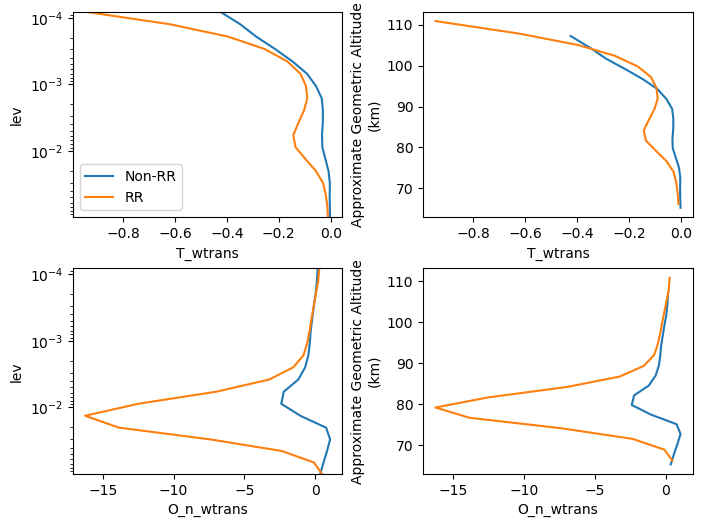

Saving files!


In [27]:
for mon,nonrr_files,rr_files,nonrr_files_z,rr_files_z in zip(month,all_wtrans_nonrr,all_wtrans_rr,all_files_nonrr_z,all_files_rr_z):
    for wtrans_nonrr_f,wtrans_rr_f,z_nonrr_file,z_rr_file in zip(nonrr_files,rr_files,nonrr_files_z,rr_files_z):
        # Get bounds of wtrans pressure range
        # Assumes nonrr and rr wtrans on same pressure range
        wtrans_nonrr = xr.open_mfdataset(wtrans_nonrr_f)
        wtrans_rr = xr.open_mfdataset(wtrans_rr_f)
        
        levU = np.min(wtrans_nonrr.lev.values)
        levL = np.max(wtrans_nonrr.lev.values)
        print('levL levU:', levL, levU)
        
        z_nonrr = xr.open_mfdataset(z_nonrr_file).sel(lev=slice(levU,levL)).isel(time=0) # only one time value in the z file, but we don't want a (1,18) shape for z
        z_rr = xr.open_mfdataset(z_rr_file).sel(lev=slice(levU,levL)).isel(time=0) 
        
        print('Non-RR lev L U:', np.max(z_nonrr.lev.values), np.min(z_nonrr.lev.values))
        print('RR lev L U:', np.max(z_rr.lev.values), np.min(z_rr.lev.values))
        
        #Add z as a variable to wtrans datasets
        wtrans_nonrr['z'] = z_nonrr['z']
        wtrans_rr['z'] = z_rr['z']
        
        if inspect_ds == True:
            print("\nNon-RR:")
            print(wtrans_nonrr.keys)
            print("\nRR:")
            print(wtrans_rr.keys)
        
        print('\nSwapping to z co-ordinates')
        wtrans_nonrr_on_z = wtrans_nonrr.swap_dims({'lev':'z'}).reset_coords('lev')
        wtrans_rr_on_z = wtrans_rr.swap_dims({'lev':'z'}).reset_coords('lev')
        
        if inspect_ds == True:
            print("\nNon-RR:")
            print(wtrans_nonrr_on_z.keys)
            print("\nRR:")
            print(wtrans_rr_on_z.keys)
        
        if plot_examples == True:
            fig = plt.figure(figsize=(8,3*len(plot_for)))
            axs=fig.subplots(nrows=len(plot_for),ncols=2)
            for i,var in enumerate(plot_for):
                wtrans_nonrr[var].plot(ax=axs[i,0],y='lev',yscale='log',ylim=[levL,levU],label='Non-RR')
                wtrans_rr[var].plot(ax=axs[i,0],y='lev',yscale='log',ylim=[levL,levU],label='RR')
                wtrans_nonrr_on_z[var].plot(ax=axs[i,1],y='z')
                wtrans_rr_on_z[var].plot(ax=axs[i,1],y='z')
                if i==0: axs[i,0].legend()
            fig.subplots_adjust(wspace=0.3,hspace=0.25)
            plt.show()
        
        if save_out == True:
            print("Saving files!")
            wtrans_nonrr_on_z.to_netcdf(path_inout + f'on_z_nonrr_{w_mm_filestr}_{year}-{mon}.nc')
            wtrans_rr_on_z.to_netcdf(path_inout + f'on_z_rr_{w_mm_filestr}_{year}-{mon}.nc')